Assignment 10 ( mini Project)

In [ ]:

# Data manipulation libraries.
import numpy as np
import pandas as pd

# Data visualization libraries.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Data modeling libraries.
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest

# General Imports
import math


# Library versions.
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

# Configure NumPy.
# Set `Line width` to Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)

# Configure Pandas.
# Set display width to maximum 130 characters in the output, post which it will continue in next line.
pd.options.display.width = 130
pd.options.display.max_rows = None

# Configure Seaborn.
sns.set_style("whitegrid")  # Set white background with grid.
sns.set_palette("deep")  # Set color palette.
sns.set_context("paper", font_scale=1.2)  # Set font to scale 1.5 more than normal.

NumPy version: 1.21.6
Pandas version: 1.3.5
Matplotlib version: 3.2.2
Seaborn version: 0.11.2


In [ ]:

def show_empty_row_count(df):
    rows, _ = df.shape
    count = []
    for col_name in df.columns.tolist():
        e_rows, _ = df[df[col_name].isna()].shape  # Empty Rows
        if e_rows > 0:
            count.append((col_name, e_rows, math.ceil(e_rows / rows * 100)))

    table = PrettyTable(["Column Name", "Empty row count", "%"], align="r")
    table.add_rows(sorted(count, key=lambda i: i[1], reverse=True))
    print(table)


def convert_n_replace(df, col_name, new_vals=None):
    """
    Function to convert given column `col_name` into Categorical type and
    replace integer values with more meaningful strings in `new_vals`.
    """
    if new_vals:
        df[col_name] = df[col_name].replace(new_vals)

    df[col_name] = df[col_name].astype("category")


# Function to get title from passenger's full name.
get_title = lambda name: name.split(", ").pop().split(". ")[0]


def create_title(df):
    """
    Function to create Categorical feature `Title` based
    on honorifics extracted from the passenger's fullname.
    """
    df["Title"] = df["Name"].apply(lambda n: n.split(", ")[1].split(". ")[0]).astype("category")


def create_age_grp(df):
    """
    Function to create Categorical feature `Age_grp`
    based on passenger's title and age (if present).
    """

    def grp_title(idf):
        name, title, age = idf[["Name", "Title", "Age"]]

        if title == "Master" or (~np.isnan(age) and age < 15):
            return "Kids"
        elif title in ["Ms", "Miss", "Mlle", "Mme", "the Countess"]:
            return "Young Females"
        elif title in ["Mr", "Rev"]:
            return "Adult Males"
        elif title in ["Mrs", "Lady", "Dona"]:
            return "Adult Females"
        else:
            return "Others"

    df["Age_grp"] = df.apply(grp_title, axis=1).astype("category")


def create_fam_count(df):
    # Sum of siblings/spouse, parents/children and self.
    df["Fam_count"] = df["SibSp"] + df["Parch"] + 1  # add self


def create_fam_size(df):
    """
    Function to create Categorical feature
    `Fam_size` based on passenger's family count.
    """

    def grp_fam_count(idf):
        # Sum of siblings/spouse, parents/children and self.
        fam_count = idf["SibSp"] + idf["Parch"] + 1

        if type(fam_count) != int:
            raise ValueError(f"Failed to compute family size. Received {type(fam_count)} type value.")

        if fam_count <= 1:
            return "Nill"
        elif fam_count <= 4:
            return "Medium"
        else:
            return "Large"

    df["Fam_size"] = df.apply(grp_fam_count, axis=1).astype("category")


def get_survival_rates(idf, col_name):
    """
    Function to get survival rates in each Family size.
    """
    n = idf[col_name].unique().size
    srv_rates = []
    for ns_name, fs_df in idf[[col_name, "Survived"]].groupby(by=[col_name]):
        t = fs_df.shape[0]
        for st_name, st_df in fs_df.groupby(by=["Survived"]):
            srv_rates.append(f"{round(st_df.shape[0] / t * 100)}%")

    return np.reshape(srv_rates, (n, 2)).transpose().flatten()


def create_cabin_count(df):
    """
    Function to create new Numerical feature `Cabin_count`(Cabin Count)
    by splitting and counting value in "Cabin" if present otherwise zero.
    """
    count_cabins = lambda c: len(c.split()) if c and type(c) == str else 0
    df["Cabin_count"] = df["Cabin"].apply(count_cabins).astype("int")


def create_cabin_cat(df):
    """
    Function to create new Categorical feature `Cabin_cat`(Cabin Category)
    by grouping cabins by their first character if present otherwise "NA".
    """
    grp_cabins = lambda c: str(c[0]) if c and type(c) == str else "NA"
    df["Cabin_cat"] = df["Cabin"].apply(grp_cabins).astype("category")


def create_log_fare(df):
    # Calculate log of Fare.
    df["Log_Fare"] = df["Fare"].apply(lambda val: math.log(val) if val > 0 else 0)


def encode_columns(df, col_names):
    lbl_en = LabelEncoder()

    for col_name in col_names:
        print(f"\nEncoding column:'{col_name}'")
        df[col_name] = lbl_en.fit_transform(df[col_name].values)

        # Verbose
        table = PrettyTable(["Label", "Encoded as"], align="r")
        table.add_rows(list(zip(lbl_en.classes_, lbl_en.transform(lbl_en.classes_))))
        print(table)


def best_k_features(X, y, k="all"):
    bst_ftrs = SelectKBest(k=k)
    fit = bst_ftrs.fit(X, y)

    col_scores = list(zip(X.columns.tolist(), fit.scores_.tolist()))

    # Sorted Column Scores.
    s_cs = sorted(col_scores, key=lambda i: i[1], reverse=True)

    # Verbose.
    table = PrettyTable(["idx", "Specs", "Score"], align="r")
    for idx, (col_name, score) in enumerate(s_cs):
        table.add_row([idx + 1, col_name, np.around(score, 1)])
    print(table)

In [ ]:
def plot_fare(df):
    """
    Function to plot ticket fare of three passenger-classes.
    """
    p_classes = df["Pclass"].value_counts().index.categories

    fig, ax = plt.subplots(nrows=1, ncols=len(p_classes), figsize=(14, 4))
    fig.suptitle("Fare distribution b/w various Passenger Class")

    for idx, class_name in enumerate(p_classes):
        fltr = df["Pclass"] == class_name
        sns.histplot(ax=ax[idx], data=df[fltr], x="Fare", kde=True)
        ax[idx].set_title(class_name)
        ax[idx].set_xlabel("Ticket Fare")
        ax[idx].set_ylabel("Count")

    plt.subplots_adjust(top=0.85)
    plt.show()

In [ ]:
psngr_df = pd.read_csv("/content/drive/MyDrive/Assignment/train.csv", index_col="PassengerId")
psngr_df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
rows, cols = psngr_df.shape
print(f"Train dataset contains {rows} and {cols}.")

Train dataset contains 891 and 11.


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Assignment/test.csv", index_col="PassengerId")
test_df.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [ ]:
t_rows, t_cols = psngr_df.shape
print(f"Test dataset contains {t_rows} and {t_cols}.")

Test dataset contains 891 and 11.


In [ ]:
psngr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
show_empty_row_count(psngr_df)

+-------------+-----------------+----+
| Column Name | Empty row count |  % |
+-------------+-----------------+----+
|       Cabin |             687 | 78 |
|         Age |             177 | 20 |
|    Embarked |               2 |  1 |
+-------------+-----------------+----+


In [ ]:
show_empty_row_count(test_df)

+-------------+-----------------+----+
| Column Name | Empty row count |  % |
+-------------+-----------------+----+
|       Cabin |             327 | 79 |
|         Age |              86 | 21 |
|        Fare |               1 |  1 |
+-------------+-----------------+----+


In [ ]:
surv_state = {0: "No", 1: "Yes"}
convert_n_replace(psngr_df, "Survived", surv_state)

p_class = {1: "First", 2: "Second", 3: "Third"}
convert_n_replace(psngr_df, "Pclass", p_class)

gender = {"male": "Male", "female": "Female"}
convert_n_replace(psngr_df, "Sex", gender)

convert_n_replace(psngr_df, "Embarked", gender)

psngr_df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,No,Third,"Braund, Mr. Owen Harris",Male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,Yes,First,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Female,38.0,1,0,PC 17599,71.2833,C85,C
3,Yes,Third,"Heikkinen, Miss. Laina",Female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
survival_status = psngr_df["Survived"].value_counts()
survival_status

No     549
Yes    342
Name: Survived, dtype: int64

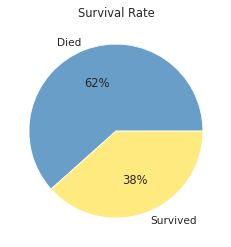

In [ ]:
labels = ["Died", "Survived"]
colors = ["#699ec9", "#ffea80"]

plt.pie(x=survival_status, labels=labels, colors=colors, autopct="%1.0f%%")
plt.title("Survival Rate")
plt.show()

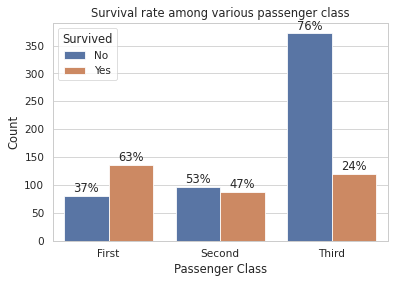

In [ ]:
plt.figure(figsize=(6, 4))

ax = sns.countplot(data=psngr_df, x="Pclass", hue="Survived")
plt.title("Survival rate among various passenger class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")

# Get survival rates in each passenger class.
srv_rates = get_survival_rates(psngr_df, "Pclass")

for index, patch in enumerate(ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.annotate(srv_rates[index] + "\n", (x, y), ha="center", va="center")

plt.show()

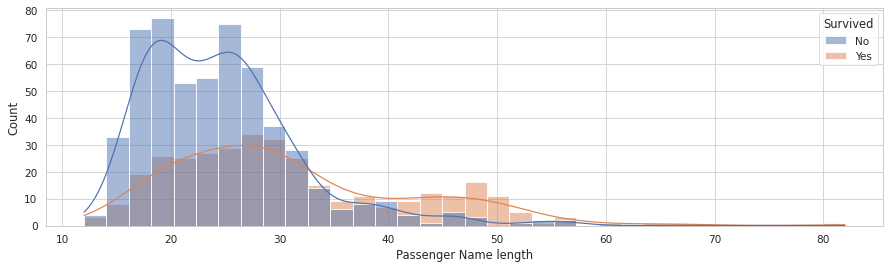

In [ ]:
psngr_df["Name_len"] = psngr_df["Name"].apply(len)

plt.figure(figsize=(15, 4))
sns.histplot(data=psngr_df, x="Name_len", hue="Survived", kde="True")
plt.xlabel("Passenger Name length")
plt.ylabel("Count")

plt.show()


In [ ]:
create_title(psngr_df)
psngr_df["Title"].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
Ms                1
Capt              1
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
Name: Title, dtype: int64

In [ ]:
create_age_grp(psngr_df)
psngr_df["Age_grp"].value_counts()

Adult Males      520
Young Females    149
Adult Females    125
Kids              82
Others            15
Name: Age_grp, dtype: int64

In [ ]:
psngr_df[["Title", "Age_grp", "Sex", "Name", "Age"]].sort_values(["Age_grp", "Age"], ascending=False).groupby("Age_grp").head(1)

,Title,Age_grp,Sex,Name,Age
PassengerId,,,,,
276,Miss,Young Females,Female,"Andrews, Miss. Kornelia Theodosia",63.0
746,Capt,Others,Male,"Crosby, Capt. Edward Gifford",70.0
112,Miss,Kids,Female,"Zabour, Miss. Hileni",14.5
631,Mr,Adult Males,Male,"Barkworth, Mr. Algernon Henry Wilson",80.0
484,Mrs,Adult Females,Female,"Turkula, Mrs. (Hedwig)",63.0


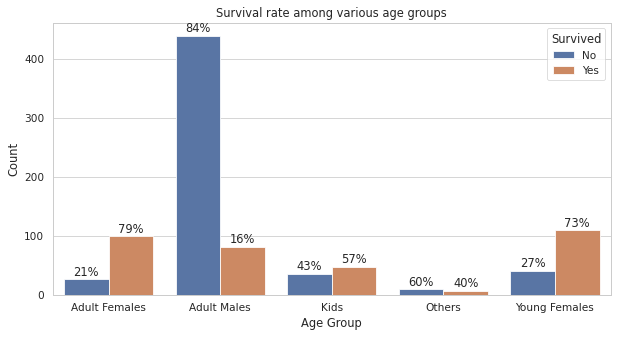

In [ ]:
plt.figure(figsize=(10, 5))

ax = sns.countplot(data=psngr_df, x="Age_grp", hue="Survived")
plt.title("Survival rate among various age groups")
plt.xlabel("Age Group")
plt.ylabel("Count")

# Get survival rates in each age group.
srv_rates = get_survival_rates(psngr_df, "Age_grp")

for index, patch in enumerate(ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.annotate(srv_rates[index] + "\n", (x, y), ha="center", va="center")

plt.show()

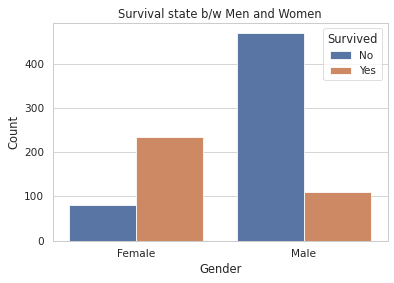

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=psngr_df, x="Sex", hue="Survived")
plt.title("Survival state b/w Men and Women")
plt.xlabel("Gender")
plt.ylabel("Count")

plt.show()

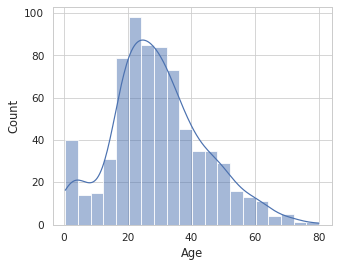

In [ ]:
fltr = ~psngr_df["Age"].isna()

plt.figure(figsize=(5, 4))
sns.histplot(data=psngr_df[fltr], x="Age", kde=True)
plt.show()

In [ ]:
create_fam_count(psngr_df)
psngr_df[["SibSp", "Parch", "Fam_count"]].head(2)

,SibSp,Parch,Fam_count
PassengerId,,,
1,1,0,2
2,1,0,2


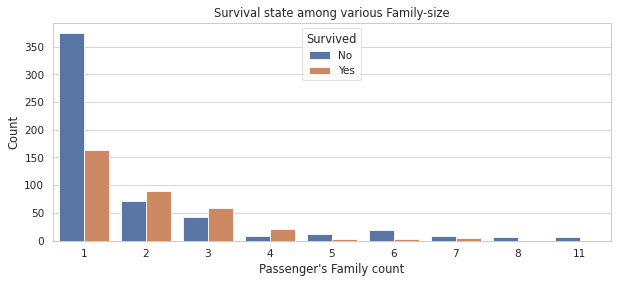

In [ ]:
plt.figure(figsize=(10, 4))

sns.countplot(data=psngr_df, x="Fam_count", hue="Survived")
plt.title("Survival state among various Family-size")
plt.xlabel("Passenger's Family count")
plt.ylabel("Count")

plt.show()

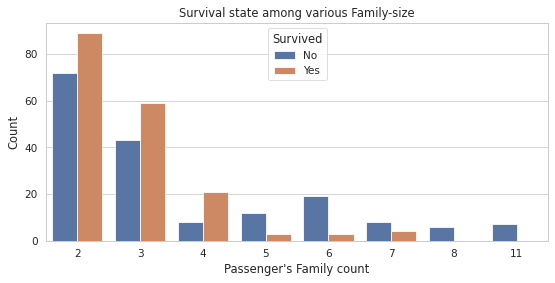

In [ ]:
plt.figure(figsize=(9, 4))

fltr = psngr_df["Fam_count"] > 1
sns.countplot(data=psngr_df[fltr], x="Fam_count", hue="Survived")
plt.title("Survival state among various Family-size")
plt.xlabel("Passenger's Family count")
plt.ylabel("Count")

plt.show()

In [ ]:
create_fam_size(psngr_df)
psngr_df[["SibSp", "Parch", "Fam_size"]].head(2)

,SibSp,Parch,Fam_size
PassengerId,,,
1,1,0,Medium
2,1,0,Medium


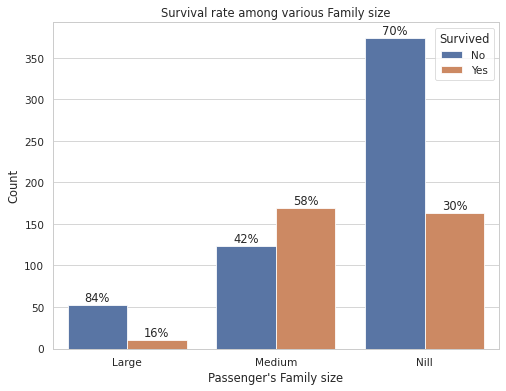

In [ ]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(data=psngr_df, x="Fam_size", hue="Survived")
plt.title("Survival rate among various Family size")
plt.xlabel("Passenger's Family size")
plt.ylabel("Count")

# Get survival rates in each family-size.
srv_rates = get_survival_rates(psngr_df, "Fam_size")

for index, patch in enumerate(ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.annotate(srv_rates[index] + "\n", (x, y), ha="center", va="center")

plt.show()


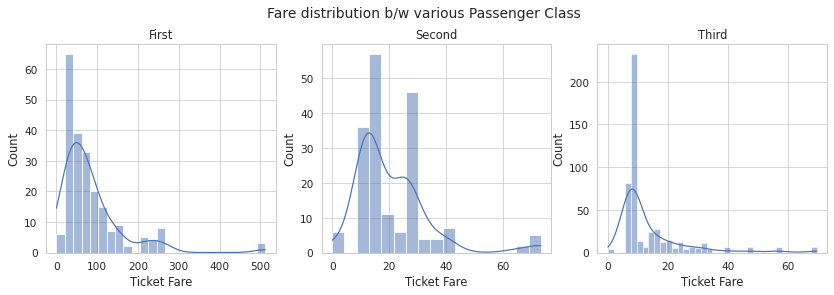

In [ ]:
plot_fare(psngr_df)

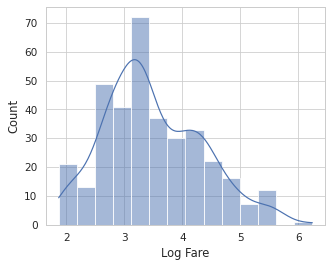

In [ ]:
create_log_fare(psngr_df)

plt.figure(figsize=(5, 4))
sns.histplot(data=psngr_df[fltr], x="Log_Fare", kde=True)
plt.xlabel("Log Fare")
plt.show()


In [ ]:
create_cabin_cat(psngr_df)
psngr_df["Cabin_cat"].value_counts()

NA    687
C      59
B      47
D      33
E      32
A      15
F      13
G       4
T       1
Name: Cabin_cat, dtype: int64

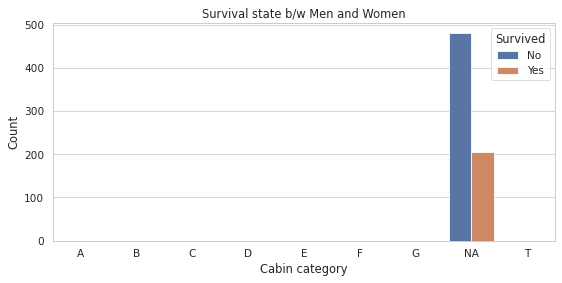

In [ ]:
plt.figure(figsize=(9, 4))

fltr = psngr_df["Cabin_cat"] == "NA"
sns.countplot(data=psngr_df[fltr], x="Cabin_cat", hue="Survived")
plt.title("Survival state b/w Men and Women")
plt.xlabel("Cabin category")
plt.ylabel("Count")

plt.show()

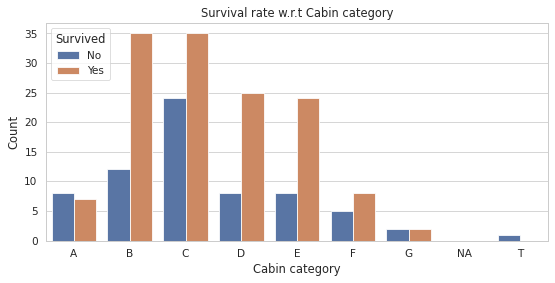

In [ ]:
plt.figure(figsize=(9, 4))

fltr = psngr_df["Cabin_cat"] != "NA"
sns.countplot(data=psngr_df[fltr], x="Cabin_cat", hue="Survived")
plt.title("Survival rate w.r.t Cabin category")
plt.xlabel("Cabin category")
plt.ylabel("Count")

plt.show()

In [ ]:
create_cabin_count(psngr_df)
psngr_df["Cabin_count"].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: Cabin_count, dtype: int64

In [ ]:
psngr_df["Pclass"].value_counts()

Third     491
First     216
Second    184
Name: Pclass, dtype: int64

In [ ]:
fltr = (psngr_df["Pclass"] == "Third") & (psngr_df["Cabin_count"] > 0)
psngr_df.loc[fltr, ["Survived", "Name", "Age", "Title", "Cabin"]].sort_values("Age")

,Survived,Name,Age,Title,Cabin
PassengerId,,,,,
206,No,"Strom, Miss. Telma Matilda",2.0,Miss,G6
11,Yes,"Sandstrom, Miss. Marguerite Rut",4.0,Miss,G6
752,Yes,"Moor, Master. Meier",6.0,Master,E121
716,No,"Soholt, Mr. Peter Andreas Lauritz Andersen",19.0,Mr,F G73
395,Yes,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",24.0,Mrs,G6
76,No,"Moen, Mr. Sigurd Hansen",25.0,Mr,F G73
824,Yes,"Moor, Mrs. (Beila)",27.0,Mrs,E121
252,No,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",29.0,Mrs,G6
430,Yes,"Pickard, Mr. Berk (Berk Trembisky)",32.0,Mr,E10


In [ ]:
def re_organize_pclass(df):
    # Add new category "Steerage".
    df["Pclass"] = df["Pclass"].cat.add_categories(["Steerage"])

    fltr = (df["Pclass"] == "Third") & (df["Cabin_count"] == 0)
    df.loc[fltr, "Pclass"] = "Steerage"

In [ ]:
re_organize_pclass(psngr_df)

In [ ]:
def is_sudo_fc(cabin_str):
    print(cabin_str)
    cabin_num = int(cabin_str[1:])
    return cabin_num > 42 and cabin_num < 69


fltr = (psngr_df["Cabin_cat"] == "E") & (psngr_df["Pclass"] != "First")

psngr_df.loc[fltr, ["Survived", "Pclass", "Cabin", "Cabin_cat"]]

,Survived,Pclass,Cabin,Cabin_cat
PassengerId,,,,
124,Yes,Second,E101,E
304,Yes,Second,E101,E
430,Yes,Third,E10,E
718,Yes,Second,E101,E
752,Yes,Third,E121,E
773,No,Second,E77,E
824,Yes,Third,E121,E


In [ ]:
psngr_df["Pclass"].value_counts()

Steerage    479
First       216
Second      184
Third        12
Name: Pclass, dtype: int64

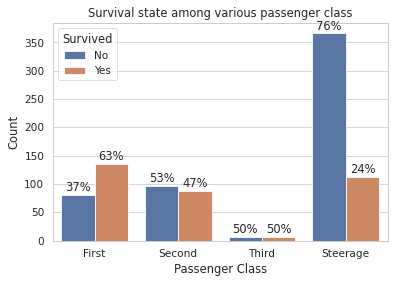

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=psngr_df, x="Pclass", hue="Survived")
plt.title("Survival state among various passenger class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")

# Get survival rates in each node stage.
srv_rates = get_survival_rates(psngr_df, "Pclass")

for index, patch in enumerate(ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.annotate(srv_rates[index] + "\n", (x, y), ha="center", va="center")

plt.show()

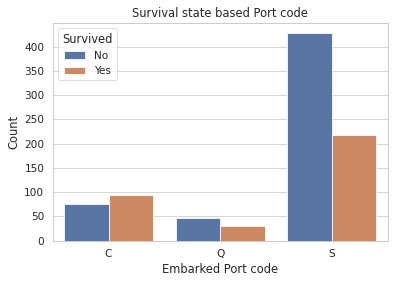

In [ ]:
plt.figure(figsize=(6, 4))

sns.countplot(data=psngr_df, x="Embarked", hue="Survived")
plt.title("Survival state based Port code")
plt.xlabel("Embarked Port code")
plt.ylabel("Count")

plt.show()

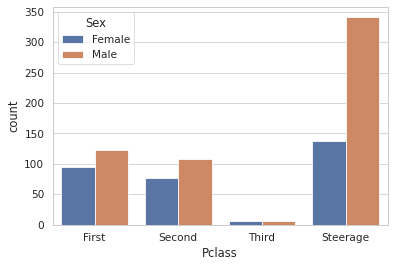

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=psngr_df, x="Pclass", hue="Sex")
plt.show()

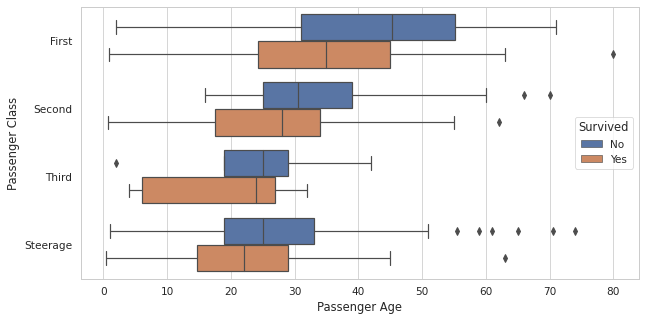

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=psngr_df, x="Age", y="Pclass", hue="Survived")
plt.xlabel("Passenger Age")
plt.ylabel("Passenger Class")

plt.show()

In [ ]:
fltr = psngr_df["Fare"] == 0
print("Passengers who did not pay any money for ticket:", len(psngr_df[fltr]))

Passengers who did not pay any money for ticket: 15


In [ ]:
fltr = psngr_df["Fare"] > 200
print("Passengers who payed more than $200 for ticket", len(psngr_df[fltr]))

Passengers who payed more than $200 for ticket 20


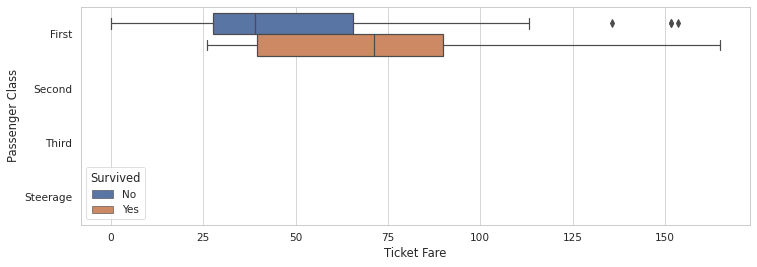

In [ ]:
plt.figure(figsize=(12, 4))

fltr = (psngr_df["Pclass"] == "First") & (psngr_df["Fare"] <= 200)
sns.boxplot(data=psngr_df[fltr], x="Fare", y="Pclass", hue="Survived")
plt.xlabel("Ticket Fare")
plt.ylabel("Passenger Class")

plt.show()

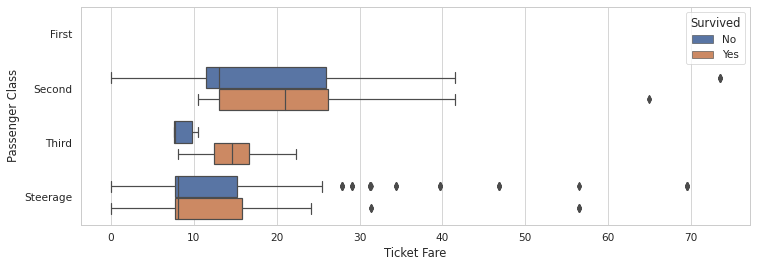

In [ ]:
plt.figure(figsize=(12, 4))

fltr = psngr_df["Pclass"] != "First"
sns.boxplot(data=psngr_df[fltr], x="Fare", y="Pclass", hue="Survived")
plt.xlabel("Ticket Fare")
plt.ylabel("Passenger Class")

plt.show()

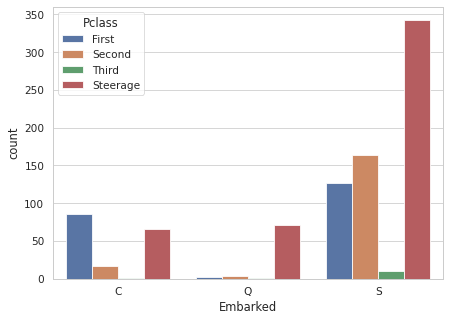

In [ ]:
plt.figure(figsize=(7, 5))

sns.countplot(data=psngr_df.sort_values(by="Pclass"), x="Embarked", hue="Pclass")
plt.yticks(ticks=range(0, 400, 50))

plt.show()

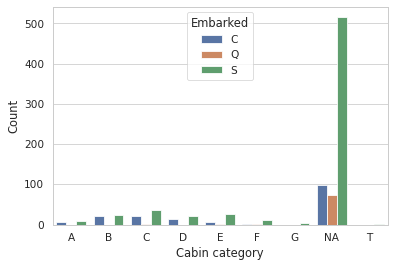

In [ ]:
plt.figure(figsize=(6, 4))

sns.countplot(data=psngr_df, x="Cabin_cat", hue="Embarked")
plt.xlabel("Cabin category")
plt.ylabel("Count")

plt.show()

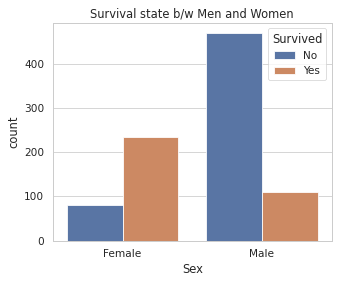

In [ ]:
plt.figure(figsize=(5, 4))
sns.countplot(data=psngr_df, x="Sex", hue="Survived")
plt.title("Survival state b/w Men and Women")
plt.show()

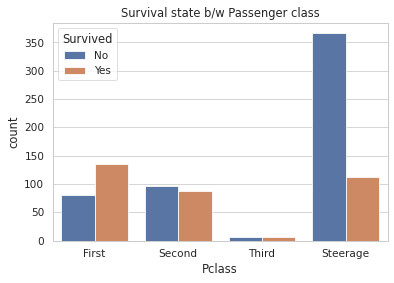

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=psngr_df, x="Pclass", hue="Survived")
plt.title("Survival state b/w Passenger class")
plt.show()

In [ ]:
median_age = psngr_df.groupby("Age_grp")["Age"].median().to_dict()

print("Median age value in Age_grp (Age group):")
print(median_age)

Median age value in Age_grp (Age group):
{'Adult Females': 35.0, 'Adult Males': 30.0, 'Kids': 4.0, 'Others': 49.0, 'Young Females': 24.0}


In [ ]:
fltr = psngr_df["Age"].isna()

get_median_age = lambda df: median_age[df["Age_grp"]]

psngr_df.loc[fltr, "Age"] = psngr_df.loc[fltr, ["Age_grp"]].apply(get_median_age, axis=1)
psngr_df.loc[fltr, ["Age_grp", "Age"]].groupby("Age_grp").head(1)

,Age_grp,Age
PassengerId,,
6,Adult Males,30.0
20,Adult Females,35.0
29,Young Females,24.0
66,Kids,4.0
767,Others,49.0


In [ ]:
fltr = psngr_df["Embarked"].isna()
psngr_df[fltr]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_len,Title,Age_grp,Fam_count,Fam_size,Log_Fare,Cabin_cat,Cabin_count
PassengerId,,,,,,,,,,,,,,,,,,,
62,Yes,First,"Icard, Miss. Amelie",Female,38.0,0,0,113572,80.0,B28,NaN,19,Miss,Young Females,1,Nill,4.382027,B,1
830,Yes,First,"Stone, Mrs. George Nelson (Martha Evelyn)",Female,62.0,0,0,113572,80.0,B28,NaN,41,Mrs,Adult Females,1,Nill,4.382027,B,1


In [ ]:
psngr_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [ ]:
psngr_df["Embarked"].fillna(value="S", inplace=True)
print("Row count with empty `Embarked` feature:", len(psngr_df[psngr_df["Embarked"].isna()]))

Row count with empty `Embarked` feature: 0


In [ ]:
en_df = psngr_df.copy()
encode_columns(en_df, ["Survived", "Pclass", "Title", "Sex", "Cabin_cat", "Embarked"])


Encoding column:'Survived'
+-------+------------+
| Label | Encoded as |
+-------+------------+
|    No |          0 |
|   Yes |          1 |
+-------+------------+

Encoding column:'Pclass'
+----------+------------+
|    Label | Encoded as |
+----------+------------+
|    First |          0 |
|   Second |          1 |
| Steerage |          2 |
|    Third |          3 |
+----------+------------+

Encoding column:'Title'
+--------------+------------+
|        Label | Encoded as |
+--------------+------------+
|         Capt |          0 |
|          Col |          1 |
|          Don |          2 |
|           Dr |          3 |
|     Jonkheer |          4 |
|         Lady |          5 |
|        Major |          6 |
|       Master |          7 |
|         Miss |          8 |
|         Mlle |          9 |
|          Mme |         10 |
|           Mr |         11 |
|          Mrs |         12 |
|           Ms |         13 |
|          Rev |         14 |
|          Sir |         15 |
| the

In [ ]:
fs_en = {
    "Medium": 0,
    "Large": 1,
    "Nill": 2,
}

en_df["Fam_size"].replace(fs_en, inplace=True)

In [ ]:
age_grp_en = {
    "Adult Females": 0,
    "Others": 1,
    "Kids": 2,
    "Young Females": 3,
    "Adult Males": 4,
}

en_df["Age_grp"].replace(age_grp_en, inplace=True)

In [ ]:
enc = ["Survived", "Pclass", "Title", "Sex", "Age_grp", "Fam_size", "Cabin_cat", "Embarked"]
en_df[enc].head(2)

,Survived,Pclass,Title,Sex,Age_grp,Fam_size,Cabin_cat,Embarked
PassengerId,,,,,,,,
1,0,2,11,1,4,0,7,2
2,1,0,12,0,0,0,2,0


In [ ]:
en_df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_len,Title,Age_grp,Fam_count,Fam_size,Log_Fare,Cabin_cat,Cabin_count
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,2,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,23,11,4,2,0,1.981001,7,0
2,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,51,12,0,2,0,4.266662,2,1


In [ ]:
1
# Except "Name", "Ticket" and "Cabin" consider all remaining features.
cns = [
    "Pclass",
    "Name_len",
    "Title",
    "Sex",
    "Age",
    "Age_grp",
    "SibSp",
    "Parch",
    "Fam_count",
    "Fam_size",
    "Fare",
    "Cabin_cat",
    "Embarked",
]

X = en_df[cns]
y = en_df["Survived"]

best_k_features(X, y)

+-----+-----------+-------+
| idx |     Specs | Score |
+-----+-----------+-------+
|   1 |       Sex | 372.4 |
|   2 |   Age_grp | 250.6 |
|   3 |  Name_len | 110.4 |
|   4 |    Pclass | 106.6 |
|   5 | Cabin_cat |  84.8 |
|   6 |      Fare |  63.0 |
|   7 |  Fam_size |  59.1 |
|   8 |     Title |  34.6 |
|   9 |  Embarked |  25.7 |
|  10 |     Parch |   6.0 |
|  11 |       Age |   5.0 |
|  12 |     SibSp |   1.1 |
|  13 | Fam_count |   0.2 |
+-----+-----------+-------+
